In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [3]:
#Importing the data
train= pd.read_csv('/content/Price_Train.csv')
test= pd.read_csv('/content/Price_Test.csv')

In [4]:
train.head()


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [5]:
train_open= train.iloc[:, 1:2].values


In [6]:
#Scaling the values between 0 to 1
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train_open_scaled= ss.fit_transform(train_open)

In [7]:
train_open_scaled[60]

array([0.08627874])

In [8]:
# Feature selection
xtrain=[]
ytrain=[]
for i in range(60,len(train_open_scaled)):
    xtrain.append(train_open_scaled[i-60:i,0])
    ytrain.append(train_open_scaled[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [9]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))

In [10]:
xtrain.shape

(1198, 60, 1)

Building the LSTM Network

In [11]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [12]:
#initialisizng the model
regression= Sequential()

#First Input layer and LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
regression.add(Dropout(0.2))

# Where:
#     return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

# Second LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Third LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
#Output layer , we wont pass any activation as its continous value model
regression.add(Dense(units=1))

#Compiling the network
regression.compile(optimizer='adam',loss='mean_squared_error')


#fitting the network
regression.fit(xtrain,ytrain,batch_size=30,epochs=100)

Epoch 1/100
40/40 [==============================] - 14s 144ms/step - loss: 0.0366
Epoch 2/100
40/40 [==============================] - 4s 109ms/step - loss: 0.0069
Epoch 3/100
40/40 [==============================] - 5s 123ms/step - loss: 0.0059
Epoch 4/100
40/40 [==============================] - 6s 142ms/step - loss: 0.0058
Epoch 5/100
40/40 [==============================] - 4s 111ms/step - loss: 0.0054
Epoch 6/100
40/40 [==============================] - 5s 126ms/step - loss: 0.0055
Epoch 7/100
40/40 [==============================] - 6s 139ms/step - loss: 0.0057
Epoch 8/100
40/40 [==============================] - 4s 110ms/step - loss: 0.0044
Epoch 9/100
40/40 [==============================] - 5s 128ms/step - loss: 0.0046
Epoch 10/100
40/40 [==============================] - 6s 137ms/step - loss: 0.0055
Epoch 11/100
40/40 [==============================] - 4s 110ms/step - loss: 0.0045
Epoch 12/100
40/40 [==============================] - 5s 131ms/step - loss: 0.0042
Epoch 13/100

In [13]:
test_open= test.iloc[:, 1:2].values #taking  open price
total= pd.concat([train['Open'],test['Open']],axis=0) # Concating train and test and then will take last 60 train point
test_input = total[len(total)-len(test)-60:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)

In [14]:
xtest= []
for i in range(60,80):
    xtest.append(test_input[i-60:i,0]) #creating input for lstm prediction

In [15]:
xtest= np.array(xtest)

In [16]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)

1/1 [==============================] - 1s 1s/step


In [17]:
predicted_value= ss.inverse_transform(predicted_value)

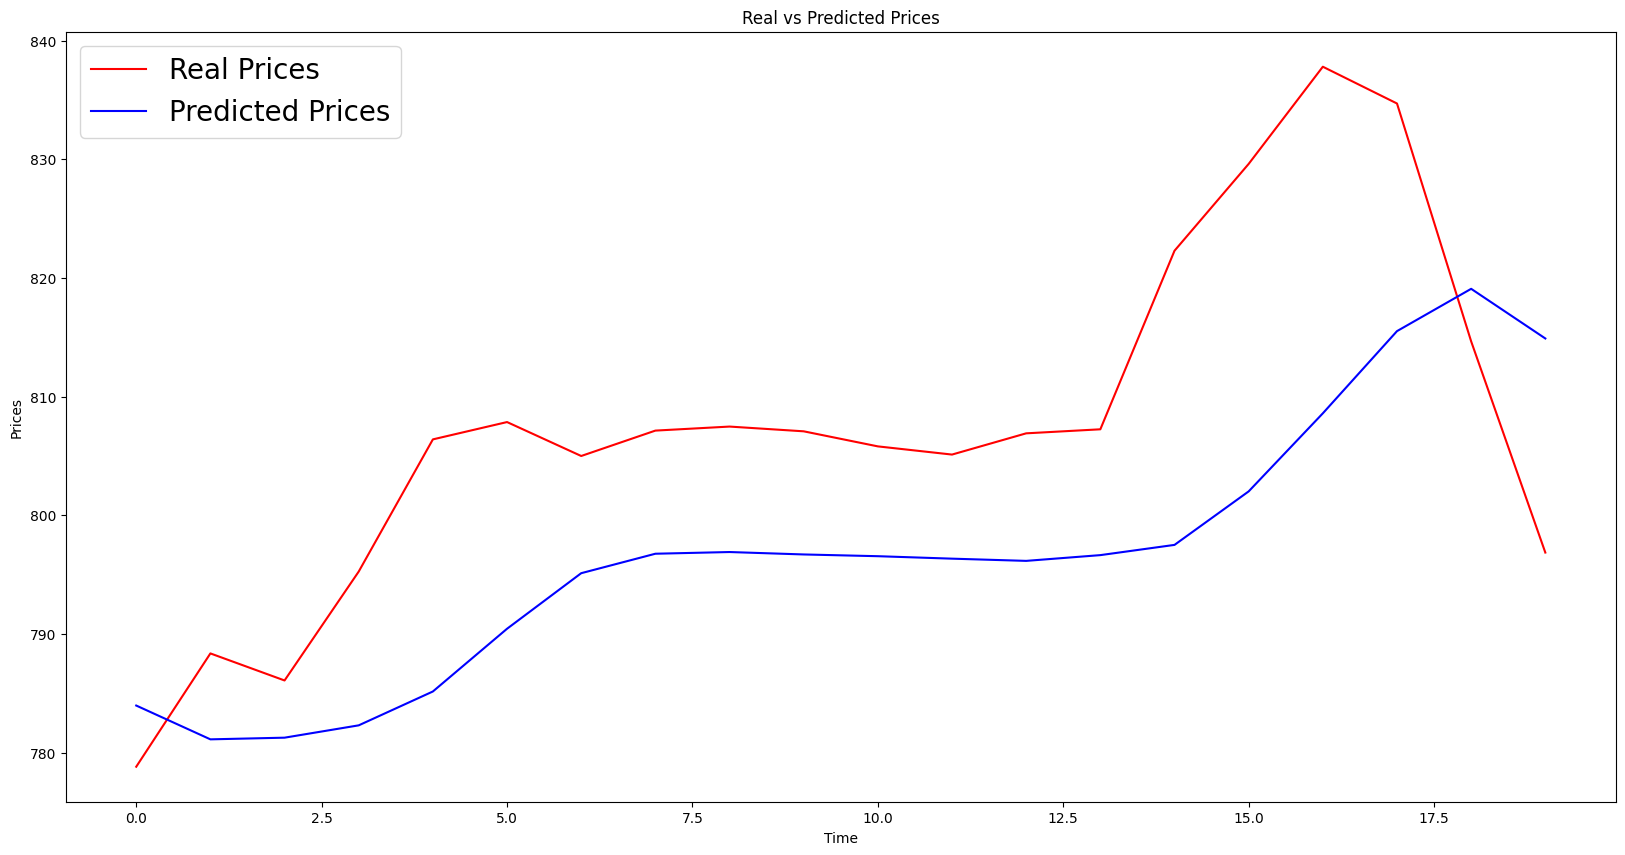

In [18]:
plt.figure(figsize=(20,10))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)